# Depth Data Analysis for DynSLAM

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from matplotlib import rc
# Enable full LaTeX support in plot text. Requires a full-fledged LaTeX installation
# on your system, accessible via PATH.
rc('text', usetex=True)

plt.rcParams["figure.figsize"] = (12, 4)

# TODO(andrei): Remember that box-and-whisker plots can be VERY informative.

In [16]:
%ls ../cmake-build-debug/*.csv

../cmake-build-debug/kitti-odometry-01-offset-30-depth-precomputed-elas-voxelsize-0.0350-results.csv
../cmake-build-debug/kitti-odometry-05-offset-2054-depth-precomputed-elas-voxelsize-0.0350-results.csv
../cmake-build-debug/kitti-odometry-06-offset-0-depth-precomputed-dispnet-voxelsize-0.0350-results.csv
../cmake-build-debug/kitti-odometry-06-offset-0-depth-precomputed-elas-voxelsize-0.0350-results.csv
../cmake-build-debug/kitti-odometry-08-offset-3969-depth-precomputed-dispnet-voxelsize-0.0350-results.csv
../cmake-build-debug/kitti-odometry-08-offset-3969-depth-precomputed-elas-voxelsize-0.0350-results.csv


In [17]:
CSV_FILE_DISPNET = "../cmake-build-debug/kitti-odometry-06-offset-0-depth-precomputed-dispnet-voxelsize-0.0350-results.csv"
# CSV_FILE_ELAS = "../cmake-build-debug/kitti-odometry-08-offset-3969-results.csv"
CSV_FILE_ELAS = "../cmake-build-debug/kitti-odometry-06-offset-0-depth-precomputed-elas-voxelsize-0.0350-results.csv"

In [40]:
frame_dn = pd.read_csv(CSV_FILE_DISPNET)
frame_elas = pd.read_csv(CSV_FILE_ELAS)
DELTA_MAX = 10

len(frame_dn), len(frame_elas)

def augment(dframe):
    for name in ['input', 'fusion']:
        for delta in range(1, DELTA_MAX+1):
            total = dframe['{}-total-{}'.format(name, delta)]
            error = dframe['{}-error-{}'.format(name, delta)]
            missing = dframe['{}-missing-{}'.format(name, delta)]
            correct = dframe['{}-correct-{}'.format(name, delta)]

            dframe['{}-error-percent-{}'.format(name, delta)] = error / total
            dframe['{}-missing-percent-{}'.format(name, delta)] = missing / total
            dframe['{}-correct-percent-{}'.format(name, delta)] = correct / total
            
            
augment(frame_dn)
augment(frame_elas)


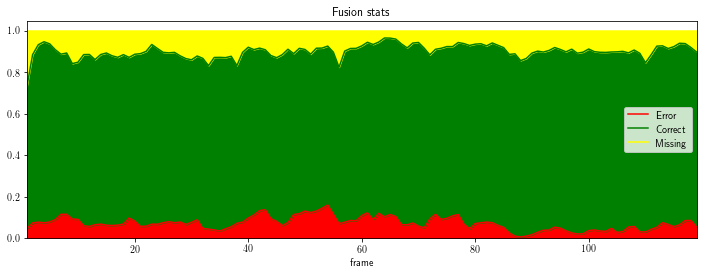

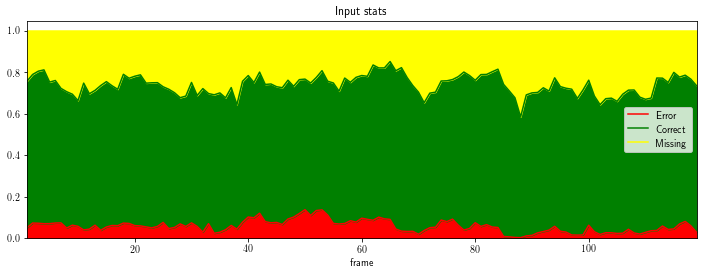

In [57]:
def timeplot(frame, delta=5):
    time_colors = ['red', 'green', 'yellow']
    time_names = ['Error','Correct','Missing']
    ax = frame.plot('frame', 
                  ['fusion-error-percent-{}'.format(delta), 
                   'fusion-correct-percent-{}'.format(delta),
                   'fusion-missing-percent-{}'.format(delta)],
                  'area',
                  stacked=True,
                  color=time_colors,
                  title="Fusion stats"
                 )
    ax.legend(time_names)

    ax2 = frame.plot('frame',
                        ['input-error-percent-{}'.format(delta),
                         'input-correct-percent-{}'.format(delta),
                         'input-missing-percent-{}'.format(delta)],
                  'area', stacked=True,
                  color=time_colors,
                  title="Input stats"
                 )
    ax2.legend(time_names)
    
timeplot(frame_elas, 9)

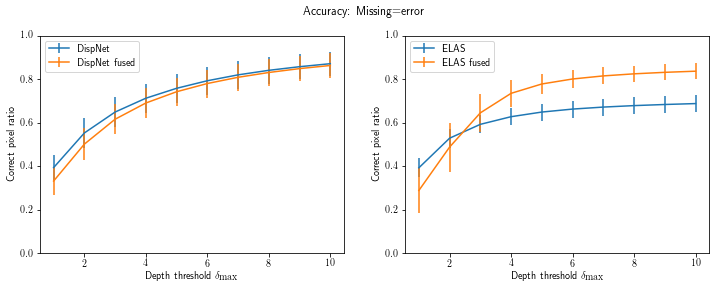

In [20]:

accs_input = []
accs_input_stds = []
accs_input_e = []
accs_input_stds_e = []
accs_fusion = []
accs_fusion_e = []
accs_fusion_stds = []
accs_fusion_stds_e = []

delta_maxes = range(1, 11)

def stats_for_delta(dframe, name, delta, include_missing):
    total = dframe['{}-total-{}'.format(name, delta)]
    error = dframe['{}-error-{}'.format(name, delta)]
    missing = dframe['{}-missing-{}'.format(name, delta)]
    correct = dframe['{}-correct-{}'.format(name, delta)]
    
    if include_missing:
        # Consider missing (uncomputed) values as errors
        accuracy = correct / total
    else:
        accuracy = correct / (total - missing)
        
    return accuracy.mean(), accuracy.std()

missing_are_errors = True
for i in delta_maxes:
    fus_acc_mean, fus_acc_std = stats_for_delta(frame_dn, 'fusion', i, missing_are_errors)
    fus_acc_mean_e, fus_acc_std_e = stats_for_delta(frame_elas, 'fusion', i, missing_are_errors)
    accs_fusion.append(fus_acc_mean)
    accs_fusion_stds.append(fus_acc_std)
    accs_fusion_e.append(fus_acc_mean_e)
    accs_fusion_stds_e.append(fus_acc_std_e)
    
    in_acc_mean, in_acc_std = stats_for_delta(frame_dn, 'input', i, missing_are_errors)
    in_acc_mean_e, in_acc_std_e = stats_for_delta(frame_elas, 'input', i, missing_are_errors)
    accs_input.append(in_acc_mean)
    accs_input_stds.append(in_acc_std)
    accs_input_e.append(in_acc_mean_e)
    accs_input_stds_e.append(in_acc_std_e)

# TODO look for best practices for mpl figures and use them
plt.subplot(121)
plt.errorbar(delta_maxes, accs_input, accs_input_stds, label='DispNet')
plt.errorbar(delta_maxes, accs_fusion, accs_fusion_stds, label='DispNet fused')
plt.xlabel(r"Depth threshold $\delta_{\textrm{max}}$")
plt.ylabel(r"Correct pixel ratio")
plt.ylim([0, 1])
plt.legend()


plt.subplot(122)
plt.errorbar(delta_maxes, accs_input_e, accs_input_stds_e, label='ELAS')
plt.errorbar(delta_maxes, accs_fusion_e, accs_fusion_stds_e, label='ELAS fused')
plt.xlabel(r"Depth threshold $\delta_{\textrm{max}}$")
plt.ylabel(r"Correct pixel ratio")
plt.ylim([0, 1])
plt.legend()

plt.suptitle("Accuracy: {}".format("Missing=error" if missing_are_errors else "Missing=ignore" ))
